In [11]:
import awkward as ak
A = ak.Array([1,2,3,4,5])
filter_A = A > 2
print(f"filter_A b4: {filter_A}")
filter_A= filter_A[filter_A]
print(f"filter_A after: {filter_A}")
A[filter_A]

filter_A b4: [False, False, True, True, True]
filter_A after: [True, True, True]


<Array [1, 2, 3] type='3 * int64'>

In [7]:
import xgboost as xgb
import argparse
#from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import awkward as ak
import dask_awkward as dak
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import tqdm
from distributed import LocalCluster, Client, progress
import os
import coffea.util as util
import time
from xgboost import plot_importance
import copy
from xgboost import plot_tree
import json
import cmsstyle as CMS
import mplhep as hep
import pickle
with open("my_data.pkl", "rb") as f:
    # pickle.dump((pred, weight), f)  #
    label, pred, weight = pickle.load(f)
def transformBdtOut(pred):
    """
    change the BDT output range from [0,1] to [-1,1]
    """
    pred = pred *2 -1
    return pred

In [15]:
binning

array([-1.        , -0.94871795, -0.8974359 , -0.84615385, -0.79487179,
       -0.74358974, -0.69230769, -0.64102564, -0.58974359, -0.53846154,
       -0.48717949, -0.43589744, -0.38461538, -0.33333333, -0.28205128,
       -0.23076923, -0.17948718, -0.12820513, -0.07692308, -0.02564103,
        0.02564103,  0.07692308,  0.12820513,  0.17948718,  0.23076923,
        0.28205128,  0.33333333,  0.38461538,  0.43589744,  0.48717949,
        0.53846154,  0.58974359,  0.64102564,  0.69230769,  0.74358974,
        0.79487179,  0.84615385,  0.8974359 ,  0.94871795,  1.        ])

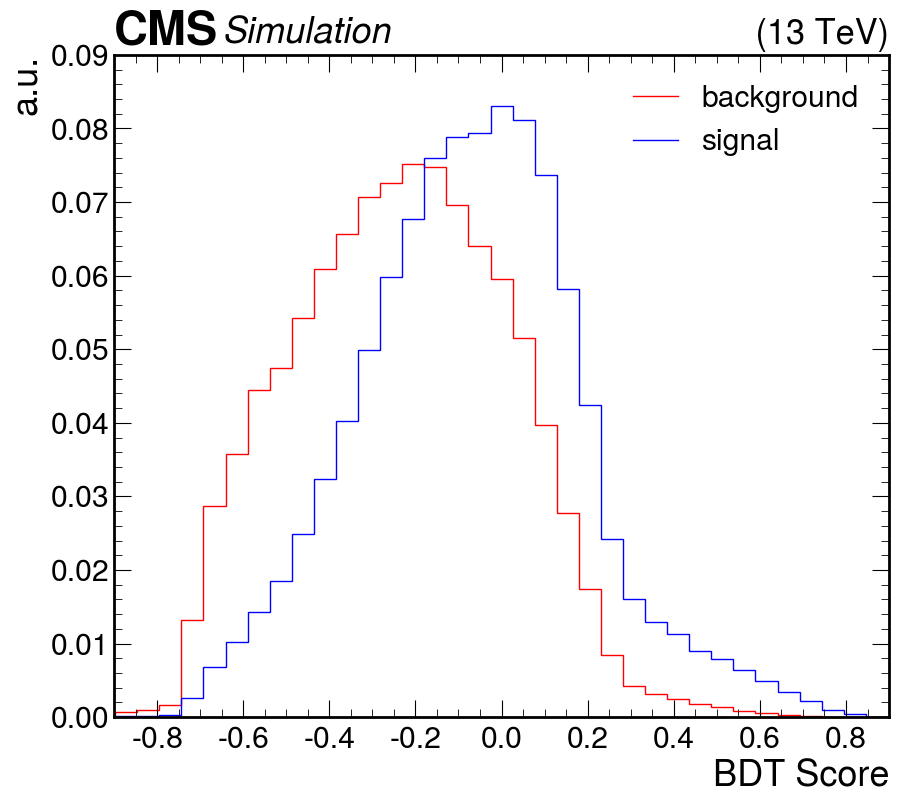

In [23]:
  
# binning = np.linspace(start=0,stop=1, num=60) 
binning = np.linspace(start=-1,stop=1, num=40) 
bkg_filter = (label ==0)
bkg_pred = transformBdtOut(pred[bkg_filter])
bkg_wgt = weight[bkg_filter]
bkg_wgt = bkg_wgt / np.sum(bkg_wgt) # normalize
bkg_hist, edges = np.histogram(bkg_pred, bins=binning, weights=bkg_wgt)
sig_filter = (label ==1)
sig_pred = transformBdtOut(pred[sig_filter])
sig_wgt = weight[sig_filter]
sig_wgt = sig_wgt / np.sum(sig_wgt) # normalize
sig_hist, _ = np.histogram(sig_pred, bins=binning, weights=sig_wgt)
# plot
fig, ax_main = plt.subplots(figsize=(10, 8.6))
ax_main.stairs(bkg_hist, edges, label = "background", color="Red")
ax_main.stairs(sig_hist, edges, label = "signal", color="Blue")


    
# Add legend and axis labels
ax_main.set_xlabel('BDT Score')
ax_main.set_ylabel("a.u.")
ax_main.legend()
# ax_main.set_aspect(0.818181818)  # height is 2× the width (in data units)


# Set Range
ax_main.set_xlim(-0.9, 0.9)
ax_main.set_xticks([ -0.8, -0.6, -0.4, -0.2 , 0. ,  0.2 , 0.4 , 0.6,  0.8])
ax_main.set_ylim(0, 0.09)

# hep.cms.label(data=True, loc=0, label=status, com=CenterOfMass, lumi=lumi, ax=ax_main)
hep.cms.label(data=False, ax=ax_main)
# plt.show()
plt.savefig("Test2.png")

In [1]:
import dask_awkward as dak
import awkward as ak
import numpy as np
import xgboost as xgb
import argparse
#from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import awkward as ak
import dask_awkward as dak
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import tqdm
from distributed import LocalCluster, Client, progress
import os
import coffea.util as util
import time
from xgboost import plot_importance
import copy
from xgboost import plot_tree
import json
import cmsstyle as CMS
import mplhep as hep
import pickle

client =  Client(n_workers=63,  threads_per_worker=1, processes=True, memory_limit='20 GiB') 

jecDefault_events = dak.from_parquet("../quick_tests/quick_save/jet_jec_off/*.parquet")[:].compute()
jecOn_events = dak.from_parquet("../quick_tests/quick_save/jet_jec_on/*.parquet")[:].compute()
# jecDefault_events = dak.from_parquet("../quick_tests/quick_save/jet_jec_off/*.parquet")[:10000].compute()
# jecOn_events = dak.from_parquet("../quick_tests/quick_save/jet_jec_on/*.parquet")[:10000].compute()


In [2]:
# jecDefault_events.fields
len(jecDefault_events)

1024235340

In [3]:
import json 
plot_setting_fname = "quick_save/plot_settings_gghCat_BDT_input.json"
with open(plot_setting_fname, "r") as file:
    plot_settings = json.load(file)

In [4]:
plot_settings.keys()

dict_keys(['dimuon_mass', 'dimuon_pt', 'dimuon_pt_log', 'dimuon_eta', 'dimuon_rap', 'dimuon_rapidity', 'dimuon_phi', 'dimuon_cos_theta_cs', 'dimuon_phi_cs', 'dimuon_cos_theta_eta', 'dimuon_phi_eta', 'dimuon_ebe_mass_res', 'dimuon_ebe_mass_res_rel', 'rpt', 'll_zstar_log', 'mmj_min_dEta', 'mmj_min_dPhi', 'njets', 'gjj_mass', 'jj_mass', 'jj_mass_range2', 'jj_eta', 'jj_pt', 'jj_dEta', 'jj_dPhi', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_qgl', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_qgl', 'mu1_pt', 'mu1_pt_over_mass', 'mu1_eta', 'mu1_phi', 'mu2_pt', 'mu2_pt_over_mass', 'mu2_eta', 'mu2_phi', 'dR', 'nBtagLoose', 'nBtagMedium', 'nsoftjets2', 'nsoftjets5', 'htsoft2', 'htsoft5', 'zeppenfeld', 'pt_centrality', 'pt_centrality_scalar'])

plotting pt
plotting histograms!
default_hist [        0 185966480 365327854 113131444  93630044  79651123  50298575
  27868228  17355061  12555961   9840425   8191789   7060144   6145013
   5461045   4743932   4193345   3610884   3206584   2810270   2437010
   2186707   1930612   1685161   1521692   1356732   1211679   1069514
    972474    878428]
jec_hist [       83 186298773 365158757 113007806  93556756  79814912  50184137
  27867295  17396084  12488937   9859544   8212162   7024149   6159207
   5434663   4769482   4180363   3641805   3187324   2799848   2459188
   2174669   1921147   1701522   1513698   1349793   1206654   1080440
    967696    874613]


/tmp/ipykernel_408700/3274491851.py:60: RuntimeWarning: divide by zero encountered in divide
  ratio = jec_hist / default_hist


plotting mass
plotting histograms!
default_hist [   567354   1204645   6069230  31371823 156846546 239641207 168910912
 107964992  72197339  50066413  35801872  26054433  19754102  15123715
  12045539   9948052   8215508   7039966   5992718   5229295   4596243
   4004178   3542611   3144089   2800362   2544573   2232314   1998909
   1793614   1613704   1477742   1304234   1173225   1061464    956552
    879880    780050    704973    637953    582539    523292    483381
    421238    399543    349401    331728    300051    263806    251855
    228686]
jec_hist [   567320   1204463   6077436  31376393 157111810 239695964 168657649
 107863310  72155461  50218075  35695747  26121989  19667538  15170078
  12091452   9887009   8239844   7005854   6012397   5245529   4557751
   4016792   3552792   3153691   2811597   2505993   2241982   2005147
   1801011   1618605   1454412   1310414   1177265   1065468    959523
    866328    783417    707894    639923    584195    520317    476575
    4304

<Figure size 800x600 with 0 Axes>

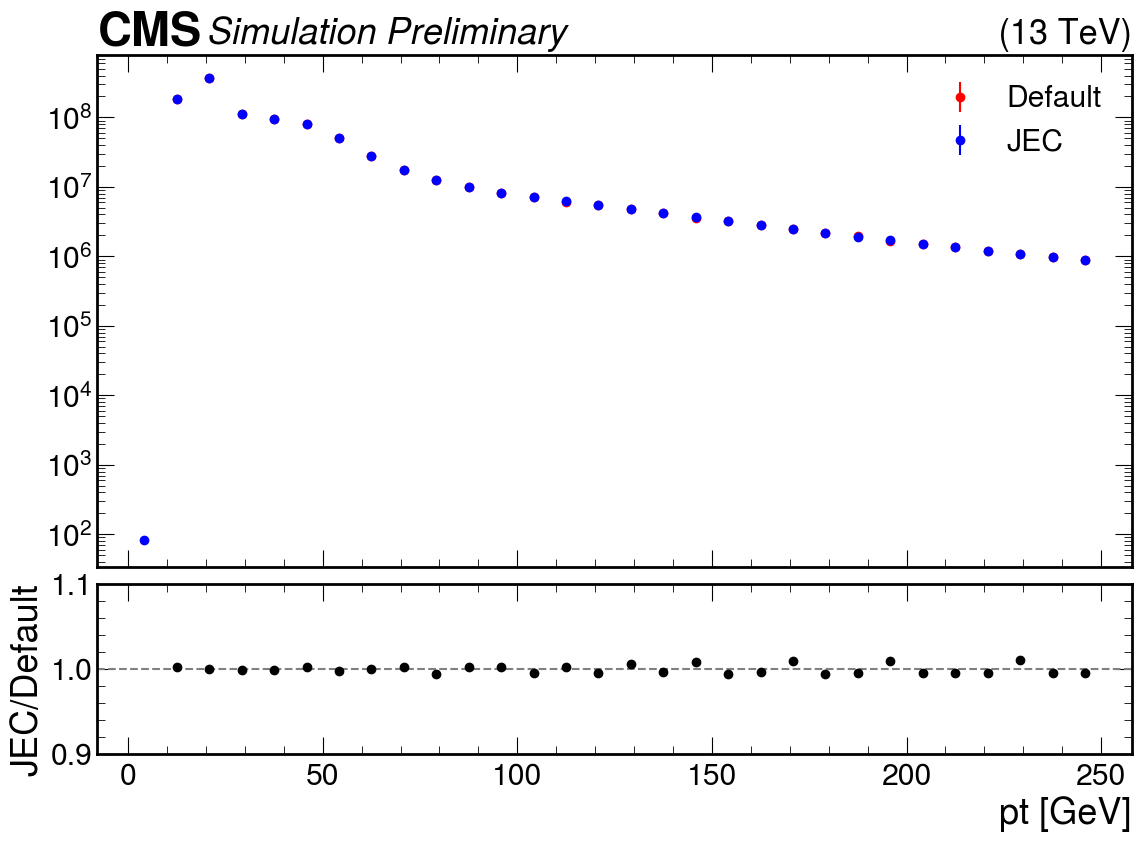

<Figure size 800x600 with 0 Axes>

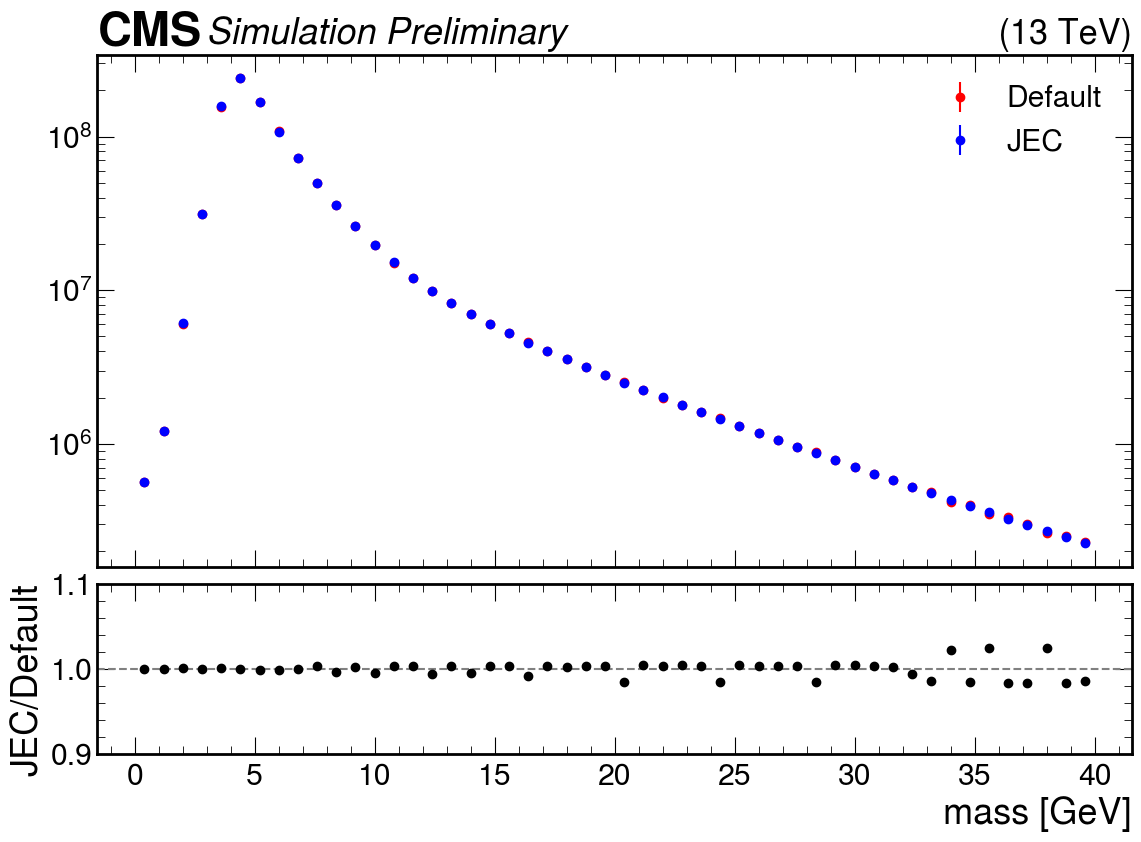

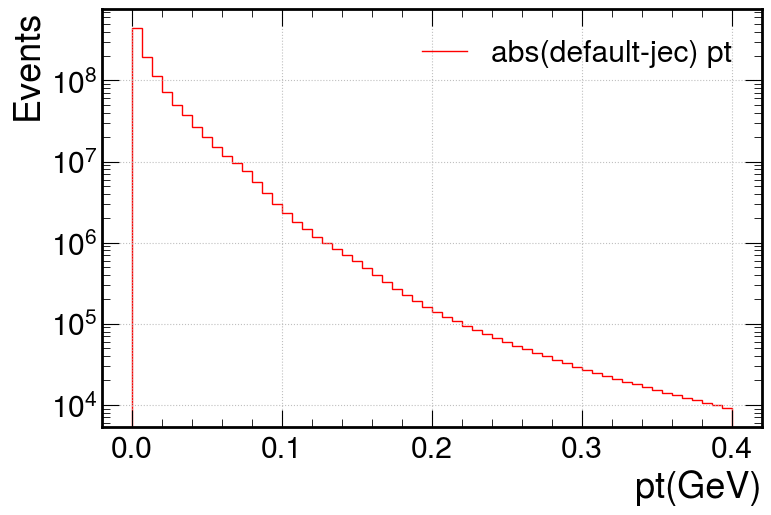

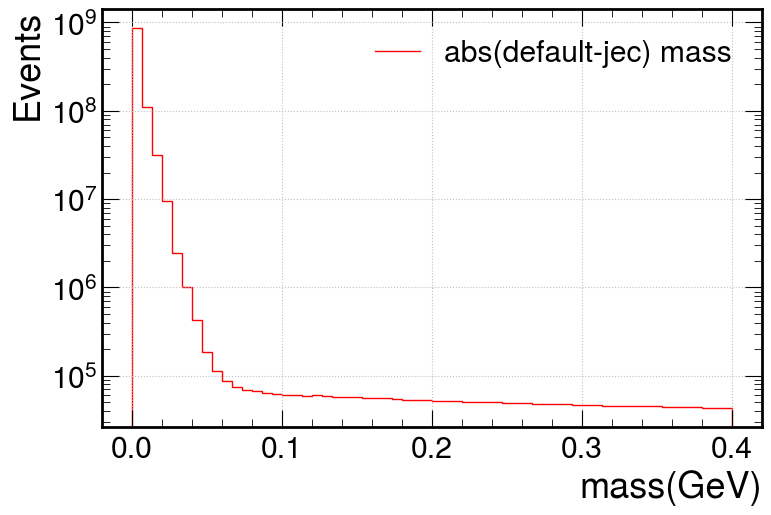

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep

# Use CMS style
plt.style.use(mplhep.style.CMS)

def plot_histograms(default_data, jec_data, binning, title, xlabel):
    print("plotting histograms!")
    plt.figure(figsize=(8, 6))
    # plt.hist(default_data, bins=bins, alpha=0.6, label='Default Jet')
    # plt.hist(jec_data, bins=bins, alpha=0.6, label='JEC Jet')
    default_hist, edges = np.histogram(default_data, bins=binning)
    print(f"default_hist {default_hist}")
    
    jec_hist, edges = np.histogram(jec_data, bins=binning)
    print(f"jec_hist {jec_hist}")


    fig, (ax_main, ax_ratio) = plt.subplots(
    2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1]}, figsize=(12, 9)
)
    
    # fig, ax_main = plt.subplots(figsize=(10, 8.6))
    # plt.stairs(default_hist, edges, label = "default", color="Red")
    # plt.stairs(jec_hist, edges, label = "jec", color="Blue")
    # plt.title(title)
    # plt.xlabel(xlabel)
    # plt.ylabel('Events')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # # plt.show()

    bin_centers = (edges[:-1] + edges[1:]) / 2
    bin_widths = np.diff(edges)
    # Main plot
    ax_main.errorbar(
        bin_centers,
        default_hist,
        yerr=np.sqrt(default_hist),  # Poisson errors
        fmt='o',
        label="Default",
        color='red'
    )
    ax_main.errorbar(
        bin_centers,
        jec_hist,
        yerr=np.sqrt(jec_hist),  # Poisson errors
        fmt='o',
        label="JEC",
        color='blue'
    )

    ax_main.legend()
    ax_main.set_yscale("log")
    mplhep.cms.label("Preliminary", ax=ax_main)
    
    # Ratio plot
    ratio = jec_hist / default_hist 
    # ratio_err = ratio * np.sqrt(1/hist1 + 1/hist2)
    
    ax_ratio.errorbar(bin_centers, ratio, fmt='o', color="black")
    ax_ratio.axhline(1, color='gray', linestyle='--')
    ax_ratio.set_ylabel("JEC/Default")
    ax_ratio.set_xlabel(f"{title} [GeV]")
    ax_ratio.set_ylim(0.9, 1.1)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)

    
    plt.savefig(f"quick_save/{title}.pdf")


def plot_diff(default_data, jec_data, xlabel):
    print("plotting histograms!")
    plt.figure(figsize=(8, 6))
    # plt.hist(default_data, bins=bins, alpha=0.6, label='Default Jet')
    # plt.hist(jec_data, bins=bins, alpha=0.6, label='JEC Jet')
    binning = np.linspace(0, 0.4, 61)
    diffs = abs(default_data-jec_data)
    diff_hist, edges = np.histogram(diffs, bins=binning)
    print(f"{xlabel} default_data {default_data}")
    print(f"{xlabel} jec_data {jec_data}")
    print(f"{xlabel} diffs {(diffs)}")

    
    # fig, ax_main = plt.subplots(figsize=(10, 8.6))
    plt.stairs(diff_hist, edges, label = f"abs(default-jec) {xlabel}", color="Red")
    plt.xlabel(xlabel+ "(GeV)")
    plt.ylabel('Events')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.yscale('log')
    # plt.show()
    plt.savefig(f"quick_save/diff_{xlabel}.pdf")

# Plot all
# for field in jecDefault_events.fields:

for field in ['pt', 'mass']:
    print(f"plotting {field}")
    try:
        binning = plot_settings[f"jet1_{field}"]["binning_linspace"]
        binning = np.linspace(*binning)
    except:
        binning = np.linspace(0,40, 51)
    # print(binning)
    default_jet = ak.to_numpy(jecDefault_events[field])
    jec_jet = ak.to_numpy(jecOn_events[field])
    plot_histograms(default_jet, jec_jet,binning, field, '')

for field in ['pt', 'mass']:
    print(f"plotting {field}")
    
    # print(binning)
    default_jet = ak.to_numpy(jecDefault_events[field])
    jec_jet = ak.to_numpy(jecOn_events[field])
    plot_diff(default_jet, jec_jet,field)

In [8]:
ak.max(abs(jecDefault_events.pt - jecOn_events.pt))

2.7070132586488107

In [27]:
print(np.min(jecDefault_events.mass))


1.0546875


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import mplhep

# # Use CMS style
# plt.style.use(mplhep.style.CMS)

# # Example data
# np.random.seed(42)
# data1 = np.random.normal(100, 15, size=1000)
# data2 = np.random.normal(105, 15, size=1000)

# bins = np.linspace(40, 160, 25)

# # Histograms
# hist1, bin_edges = np.histogram(data1, bins=bins)
# hist2, _ = np.histogram(data2, bins=bins)

# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# bin_widths = np.diff(bin_edges)

# # --- Plotting ---
# fig, (ax_main, ax_ratio) = plt.subplots(
#     2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 6)
# )

# # Main plot
# ax_main.errorbar(bin_centers, hist1, yerr=np.sqrt(hist1), fmt='o', label="Data")
# ax_main.bar(bin_centers, hist2, width=bin_widths, alpha=0.5, label="MC", align="center")
# ax_main.set_ylabel("Events")
# ax_main.legend()
# mplhep.cms.label("Preliminary", ax=ax_main)

# # Ratio plot
# ratio = hist1 / hist2
# ratio_err = ratio * np.sqrt(1/hist1 + 1/hist2)

# ax_ratio.errorbar(bin_centers, ratio, yerr=ratio_err, fmt='o', color="black")
# ax_ratio.axhline(1, color='gray', linestyle='--')
# ax_ratio.set_ylabel("Data/MC")
# ax_ratio.set_xlabel("Observable [units]")

# plt.tight_layout()
# plt.subplots_adjust(hspace=0.05)
# plt.show()
